## Dataset Link : https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1 <br>
Paper 1 Link: https://arxiv.org/abs/1804.03999 <br>
Paper 2 Link: https://arxiv.org/abs/1505.04597  <br>
Paper 3 Link : https://www.mdpi.com/1424-8220/21/9/2978  <br>
Paper 4 Link : https://arxiv.org/abs/2305.17033 <br>


##  Importing all the useful Libraries

In [1]:

# %pip install scikit-learn tifffile

import numpy as np
import matplotlib.pyplot as plt 
import nibabel as nib   # Use for reading and writing neuroimaging file formats (like NIfTI)
import glob             # Use for finding the file of specific formats (txt_files = glob.glob("*.txt") give all txt file)    
from tensorflow.keras.utils import to_categorical
 # Help to convert integer labels to one-hot encoded categorical labels
from sklearn.preprocessing import MinMaxScaler # Used for scaling teh array to a given range (e.g., 0 to 1).
# from tifffile import imsave  # imsave is not available in your tifffile version; remove or use tifffile.imwrite if needed
import os
# from tqdm import tqdm  #  Visual progress bar in the terminal or notebook    80%|███████████████▍    | 16/20 
import random
import plotly.graph_objects as go
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from ipywidgets import interact, FloatSlider   # Use for making Intract
import ipywidgets as widgets
from tensorflow.keras.models import load_model
# import keras

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model

## Data Generator

In [3]:
def load_img(img_dir, img_list):
    images = []
    for image_name in img_list:
        path = os.path.join(img_dir, image_name)

        if image_name.endswith('.npy'):
            img_array = np.load(path).astype(np.float32)  # Cast here

        elif image_name.endswith('.npz'):
            data = np.load(path)
            first_key = list(data.keys())[0]
            img_array = data[first_key].astype(np.float32)  # Cast here

        else:
            continue  # skip unsupported formats

        images.append(img_array)

    images = np.array(images)
    return images

In [4]:
from scipy.ndimage import zoom
import numpy as np

def resize_volume(volume, target_shape, is_mask=False):
    order = 0 if is_mask else 1  # Nearest for masks, trilinear for images
    
    # Case 1: Single volume 3D (H, W, D)
    if volume.ndim == 3:
        spatial_shape = volume.shape
        factors = [target_shape[i] / spatial_shape[i] for i in range(3)]
        return zoom(volume, factors, order=order)
    
    # Case 2: Single volume 4D (H, W, D, C)
    if volume.ndim == 4:
        spatial_shape = volume.shape[:3]
        factors = [target_shape[i] / spatial_shape[i] for i in range(3)] + [1]
        return zoom(volume, factors, order=order)
    
    # Case 3: Batch of volumes 5D (B, H, W, D, C)
    if volume.ndim == 5:
        resized_batch = []
        for v in volume:  # Iterate over batch
            spatial_shape = v.shape[:3]
            factors = [target_shape[i] / spatial_shape[i] for i in range(3)] + [1]
            resized_batch.append(zoom(v, factors, order=order))
        return np.stack(resized_batch, axis=0)
    
    raise ValueError(f"Unexpected volume shape: {volume.shape}")

In [5]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size, target_shape=(64,64,64)):
    L = len(img_list)
    print("Total images:", L)
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < L:
            limit = min(batch_end, L)
            # Load
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])
            
            # Normalize images (0–1)
            X = (X - np.min(X)) / (np.max(X) - np.min(X) + 1e-8)
            
            # Resize to target_shape
            X = resize_volume(X, target_shape, is_mask=False)
            Y = resize_volume(Y, target_shape, is_mask=True)
            
            yield (X, Y)
            batch_start += batch_size
            batch_end += batch_size

In [6]:
train_img_dir = r"D:\MRI_Dataset\Training\Images"
train_mask_dir = r"D:\MRI_Dataset\Training\Masks"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_dir = r"D:\MRI_Dataset\Validation\Images"
val_mask_dir = r"D:\MRI_Dataset\Validation\Masks"
val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

test_img_dir= r"D:\MRI_Dataset\Test\Images"
test_mask_dir= r"D:\MRI_Dataset\Test\Masks"
test_img_list=os.listdir(test_img_dir)
test_mask_list = os.listdir(test_mask_dir)

In [7]:
print(train_img_list)
print(train_mask_list)
print(val_img_list)
print(val_mask_list)
print(test_img_list)
print(test_mask_list)

['BraTS2021_00000_combined_processed_img.npy', 'BraTS2021_00002_combined_processed_img.npy', 'BraTS2021_00003_combined_processed_img.npy', 'BraTS2021_00005_combined_processed_img.npy', 'BraTS2021_00006_combined_processed_img.npy', 'BraTS2021_00008_combined_processed_img.npy', 'BraTS2021_00009_combined_processed_img.npy', 'BraTS2021_00011_combined_processed_img.npy', 'BraTS2021_00012_combined_processed_img.npy', 'BraTS2021_00014_combined_processed_img.npy', 'BraTS2021_00016_combined_processed_img.npy', 'BraTS2021_00017_combined_processed_img.npy', 'BraTS2021_00018_combined_processed_img.npy', 'BraTS2021_00019_combined_processed_img.npy', 'BraTS2021_00020_combined_processed_img.npy', 'BraTS2021_00021_combined_processed_img.npy', 'BraTS2021_00022_combined_processed_img.npy', 'BraTS2021_00024_combined_processed_img.npy', 'BraTS2021_00025_combined_processed_img.npy', 'BraTS2021_00026_combined_processed_img.npy', 'BraTS2021_00028_combined_processed_img.npy', 'BraTS2021_00030_combined_process

In [8]:
target_shape = (64,64,64)

In [9]:
train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                 train_mask_dir, train_mask_list, batch_size=2, target_shape=target_shape)
val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                 val_mask_dir, val_mask_list, batch_size=2, target_shape=target_shape)
test_img_datagen=imageLoader(test_img_dir,test_img_list,
                                 test_mask_dir, test_mask_list, batch_size=2, target_shape=target_shape)

In [10]:
msk = np.random.randint(0, 2, size=(10, 256, 256, 3)) #10 masks, 256x256, 3 classes (one-hot or similar)
msk = msk.astype(np.float32) # Ensure it's float32 initially as per your load_img
img, msk = next(train_img_datagen)

Total images: 260


In [ ]:
from scipy.ndimage import zoom
import numpy as np

def resize_volume(volume, target_shape, is_mask=False):
    order = 0 if is_mask else 1  # Nearest for masks, trilinear for images
    
    #  Single volume 3D (H, W, D)
    if volume.ndim == 3:
        spatial_shape = volume.shape
        factors = [target_shape[i] / spatial_shape[i] for i in range(3)]
        return zoom(volume, factors, order=order)
    
    #  Single volume 4D (H, W, D, C)
    if volume.ndim == 4:
        spatial_shape = volume.shape[:3]
        factors = [target_shape[i] / spatial_shape[i] for i in range(3)] + [1]
        return zoom(volume, factors, order=order)
    
    # Batch of volumes 5D (B, H, W, D, C)
    if volume.ndim == 5:
        resized_batch = []
        for v in volume:  # Iterate over batch
            spatial_shape = v.shape[:3]
            factors = [target_shape[i] / spatial_shape[i] for i in range(3)] + [1]
            resized_batch.append(zoom(v, factors, order=order))
        return np.stack(resized_batch, axis=0)
    
    raise ValueError(f"Unexpected volume shape: {volume.shape}")

In [ ]:
img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

target_shape = (64, 64, 64)  # Adjust to your network input
img = resize_volume(img, target_shape, is_mask=False)
msk = resize_volume(msk, target_shape, is_mask=True)

In [13]:
from keras.layers import Conv3D, UpSampling3D, Activation, Add, Multiply

def attention_gate(x, g, inter_channels):
    """
    Attention Gate for 3D U-Net
    x: encoder feature
    g: decoder feature (gate signal)
    inter_channels: intermediate channel size
    """
    theta_x = Conv3D(inter_channels, (1, 1, 1), strides=(1, 1, 1), padding='same')(x)
    phi_g = Conv3D(inter_channels, (1, 1, 1), strides=(1, 1, 1), padding='same')(g)

    add_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)

    psi = Conv3D(1, (1, 1, 1), strides=(1, 1, 1), padding='same')(act_xg)
    psi = Activation('sigmoid')(psi)

    attn_coeff = Multiply()([x, psi])
    return attn_coeff


In [16]:
from keras.layers import Input, Conv3D, Conv3DTranspose, MaxPooling3D, Dropout, concatenate
from keras.models import Model

def attention_unet_3d_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    # Encoder
    c1 = Conv3D(16, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(c4)
    p4 = MaxPooling3D((2, 2, 2))(c4)

    c5 = Conv3D(256, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(c5)

    # Decoder + Attention
    u6 = Conv3DTranspose(128, 2, strides=(2, 2, 2), padding='same')(c5)
    a4 = attention_gate(c4, u6, 64)
    u6 = concatenate([u6, a4])
    c6 = Conv3D(128, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(c6)

    u7 = Conv3DTranspose(64, 2, strides=(2, 2, 2), padding='same')(c6)
    a3 = attention_gate(c3, u7, 32)
    u7 = concatenate([u7, a3])
    c7 = Conv3D(64, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(c7)

    u8 = Conv3DTranspose(32, 2, strides=(2, 2, 2), padding='same')(c7)
    a2 = attention_gate(c2, u8, 16)
    u8 = concatenate([u8, a2])
    c8 = Conv3D(32, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(c8)

    u9 = Conv3DTranspose(16, 2, strides=(2, 2, 2), padding='same')(c8)
    a1 = attention_gate(c1, u9, 8)
    u9 = concatenate([u9, a1])
    c9 = Conv3D(16, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(c9)

    outputs = Conv3D(num_classes, 1, activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    return model

In [18]:
# If your MRI data is RGB and depth=128, redefine the model like this:
model = attention_unet_3d_model(
    IMG_HEIGHT=64,
    IMG_WIDTH=64,
    IMG_DEPTH=64,
    IMG_CHANNELS=3,    # for RGB MRI or synthetic data
    num_classes=4
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2025-07-28 18:38:37.474368: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-28 18:38:37.599270: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-28 18:38:37.599341: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-28 18:38:37.601051: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-28 18:38:37.601121: I external/local_xla/xla/stream_executor

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 64, 64,    │      1,312 │ input_layer[0][0] │
│                     │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ conv3d[0][0]      │
│                     │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 64, 64,    │      6,928 │ dropout[0][0]     │
│                     │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 32, 32,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 32, 32,    │     13,856 │ max_pooling3d[0]… │
│                     │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ conv3d_2[0][0]    │
│                     │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 32, 32,    │     27,680 │ dropout_1[0][0]   │
│                     │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 16, 16,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 16, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 16, 16,    │     55,360 │ max_pooling3d_1[… │
│                     │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ conv3d_4[0][0]    │
│                     │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 16, 16,    │    110,656 │ dropout_2[0][0]   │
│                     │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 8, 8, 8,   │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 8, 8, 8,   │    221,312 │ max_pooling3d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 8,   │          0 │ conv3d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 8, 8, 8,   │    442,496 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 4, 4, 4,   │          0 │ conv3d_7[0][0]  

 Total params: 5,667,952 (21.62 MB)

 Trainable params: 5,667,952 (21.62 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25

import segmentation_models_3D as sm
from tensorflow.keras.models import Model

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

Segmentation Models: using `keras` framework.


## For training from scratch 

In [20]:
model.compile(
    optimizer='adam',
    loss=total_loss,
    metrics=metrics
)

In [21]:
#Fit the model 
batch_size=2

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

## Training

In [ ]:
# Try reducing batch size to 1 to avoid memory errors
history = model.fit(
    train_img_datagen,
    steps_per_epoch=steps_per_epoch,
    epochs=8,
    verbose=1,
    validation_data=val_img_datagen,
    validation_steps=val_steps_per_epoch,
    batch_size=1  # Add this line if not using a generator, otherwise set batch_size=1 in your generator
)

Epoch 1/8
400/400 ━━━━━━━━━━━━━━━━━━━━ 363s 909ms/step - accuracy: 0.9667 - iou_score: 0.4602 - loss: 0.8739 - val_accuracy: 0.9453 - val_iou_score: 0.3345 - val_loss: 0.9065
Epoch 2/8
400/400 ━━━━━━━━━━━━━━━━━━━━ 6432s 16s/step - accuracy: 0.9651 - iou_score: 0.4500 - loss: 0.8743 - val_accuracy: 0.9706 - val_iou_score: 0.4350 - val_loss: 0.8809
Epoch 3/8
400/400 ━━━━━━━━━━━━━━━━━━━━ 665s 2s/step - accuracy: 0.9704 - iou_score: 0.5092 - loss: 0.8580 - val_accuracy: 0.9734 - val_iou_score: 0.4644 - val_loss: 0.8707
Epoch 4/8
 47/400 ━━━━━━━━━━━━━━━━━━━━ 7:14 1s/step - accuracy: 0.9732 - iou_score: 0.5064 - loss: 0.8568

## Saving the model

In [23]:
model.save('/mnt/d/my_model_ag.keras')

## Load the model

In [15]:

def comparison(model_path, test_img_datagen, batch_size=2, 
                                         img_height=64, img_width=64, img_depth=64, 
                                         num_classes=4, num_visualizations=2, channel_to_display=1):
    # Load model
    model = load_model(model_path, compile=False)
    # Get a batch of test images and masks
    test_image_batch, test_mask_batch = next(test_img_datagen)

    # Run model prediction
    test_pred_batch = model.predict(test_image_batch)
    
    # Convert predictions and masks to class labels (argmax)
    test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)
    test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)

    # Visualization
    for i in range(min(batch_size, num_visualizations)):
        n_slice = np.random.randint(0, test_pred_batch_argmax.shape[2])  # Random slice along depth
        plt.figure(figsize=(12, 8))

        plt.subplot(1, 3, 1)
        plt.imshow(test_image_batch[i, :, :, n_slice, channel_to_display], cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(test_mask_batch_argmax[i, :, :, n_slice], cmap='viridis')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(test_pred_batch_argmax[i, :, :, n_slice], cmap='viridis')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


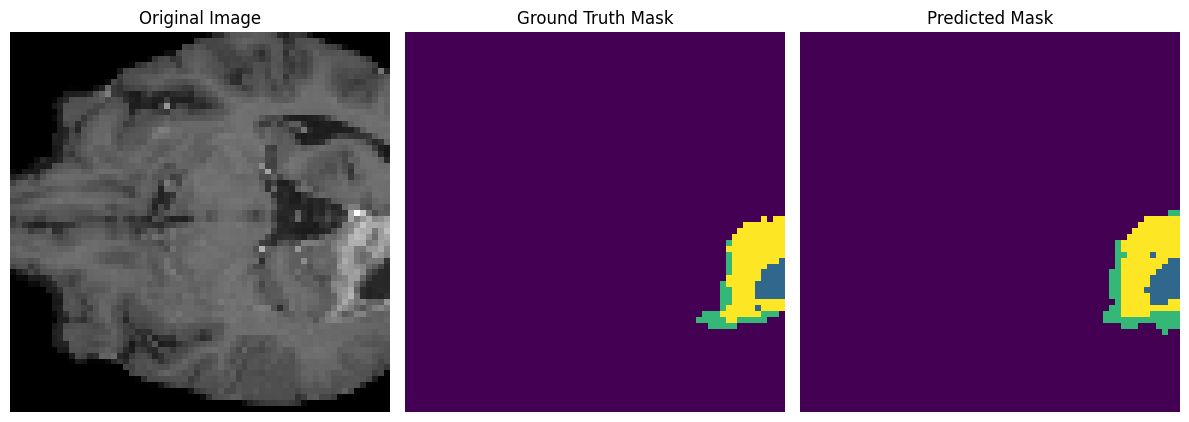

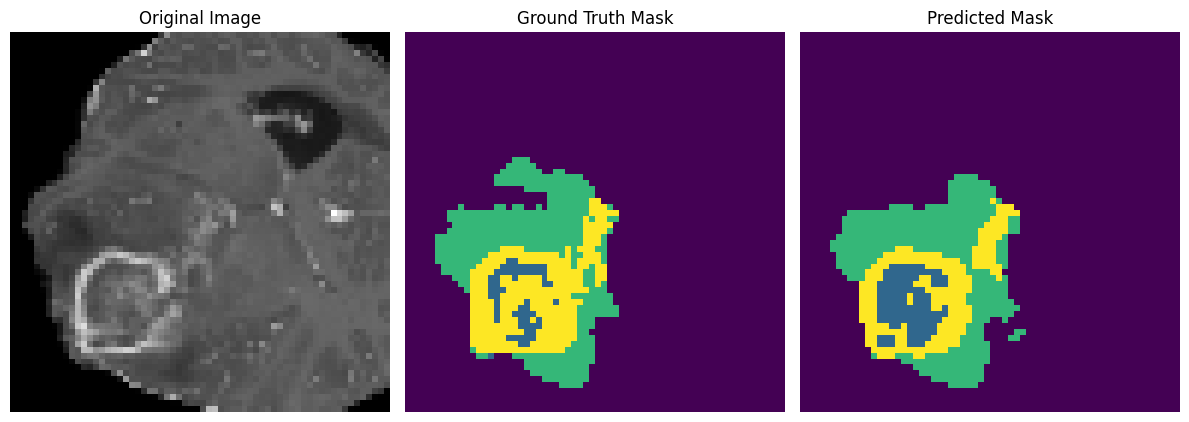

In [ ]:
model_path=r".\Desktop\krishna\my_model_ag.keras" 
comparison(model_path,test_img_datagen, batch_size=2, 
                                         img_height=64, img_width=64, img_depth=64, 
                                         num_classes=4, num_visualizations=2, channel_to_display=1)